## Codebase for bank marketing dataset classification using boosting techniques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from dataset import get_data

df = get_data()
print(df.head())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

Pipeline preprocessing

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

X = df.drop(columns=['y'])
y = df['y']

def preprocessing_pipeline(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    smote_tomek = SMOTETomek(random_state=random_state)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

    return X_resampled, X_test, y_resampled, y_test

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


### Baseline

Logistic regression

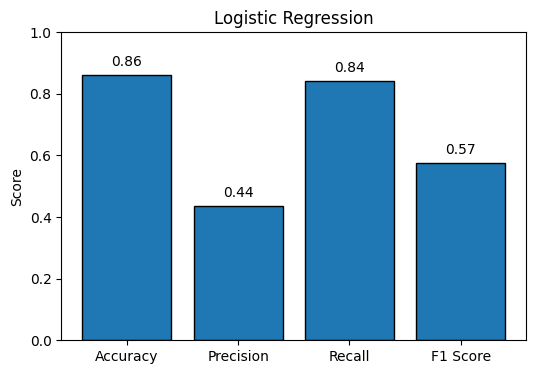

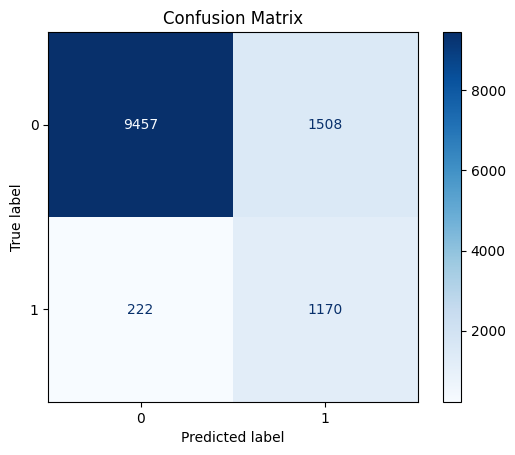

Accuracy: 0.8600
Recall: 0.8405
Precision: 0.4369
F1 Score: 0.5749
Confusion Matrix: TN=1170, FP=222, FN=1508, TP=9457


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df)

lr = LogisticRegression(max_iter=100, random_state=42)
lr.fit(X_resampled, y_resampled)

y_pred = lr.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

plt.figure(figsize=(6,4))
bars = plt.bar(metrics.keys(), metrics.values(), edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Logistic Regression')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

### Boosting Model

AdaBoost

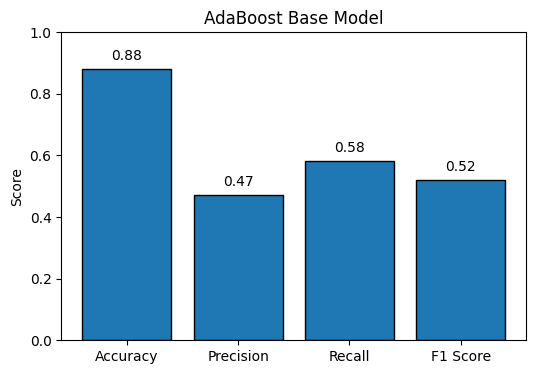

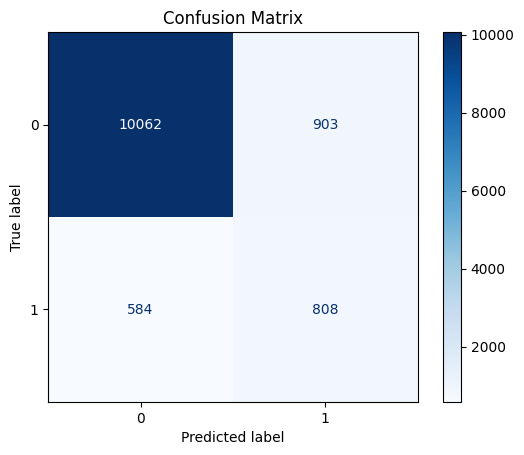

Accuracy: 0.8797
Recall: 0.5805
Precision: 0.4722
F1 Score: 0.5208
Confusion Matrix: TN=808, FP=584, FN=903, TP=10062


In [6]:
#Base Model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df)

adb = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
adb.fit(X_resampled, y_resampled)

y_pred = adb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

plt.figure(figsize=(6,4))
bars = plt.bar(metrics.keys(), metrics.values(), edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('AdaBoost Base Model')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

In [5]:
#Optimized Model GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df)

param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [ 0.01, 0.1, 0.3, 0.5, 1.0],
}

adb = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)

grid_search = GridSearchCV(adb, param_grid, cv=cv_10fold(), scoring='f1', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)


best_adb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

opt_adb = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=best_adb.n_estimators, learning_rate=best_adb.learning_rate, random_state=42)
opt_adb.fit(X_resampled, y_resampled)

y_pred = opt_adb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 50}
Accuracy: 0.8797
Recall: 0.5805
Precision: 0.4722
F1 Score: 0.5208
Confusion Matrix: TN=10062, FP=903, FN=584, TP=808


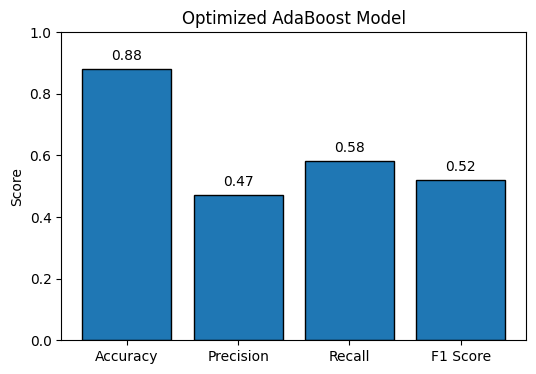

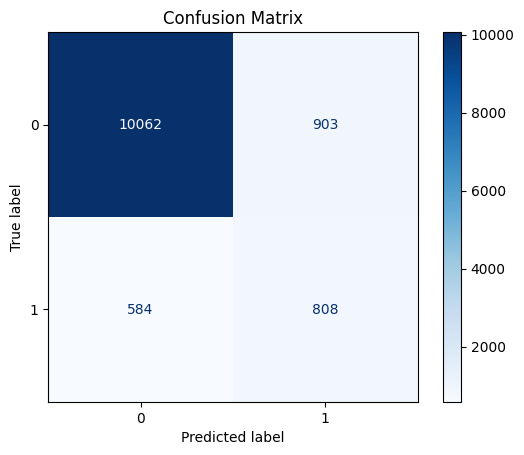

Accuracy: 0.8797
Recall: 0.5805
Precision: 0.4722
F1 Score: 0.5208
Confusion Matrix: TN=808, FP=584, FN=903, TP=10062


In [4]:
#Optimized Model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df)

opt_adb = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), learning_rate=0.01, n_estimators=50, random_state=42)
opt_adb.fit(X_resampled, y_resampled)

y_pred = opt_adb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

plt.figure(figsize=(6,4))
bars = plt.bar(metrics.keys(), metrics.values(), edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Optimized AdaBoost Model')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

Gradient Boosting

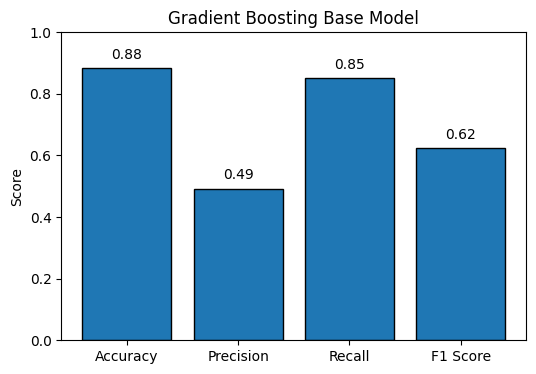

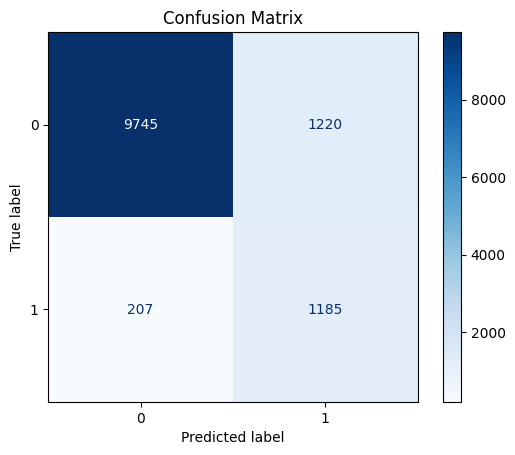

Accuracy: 0.8845
Recall: 0.8513
Precision: 0.4927
F1 Score: 0.6242
Confusion Matrix: TN=1185, FP=207, FN=1220, TP=9745


In [7]:
#Base Model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df)

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_resampled, y_resampled)

y_pred = gb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

plt.figure(figsize=(6,4))
bars = plt.bar(metrics.keys(), metrics.values(), edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Gradient Boosting Base Model')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

In [ ]:
#Optimized Model using GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df))

param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3, 0.5, 1.0],
    'max_depth': [3, 5, 7]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

best_gb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

opt_gb = GradientBoostingClassifier(
    n_estimators=best_gb.n_estimators,
    learning_rate=best_gb.learning_rate,
    max_depth=best_gb.max_depth,
    random_state=42
)

opt_gb.fit(X_resampled, y_resampled)
y_pred = opt_gb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Accuracy: 0.9120
Recall: 0.6466
Precision: 0.6020
F1 Score: 0.6235
Confusion Matrix: TN=10370, FP=595, FN=492, TP=900


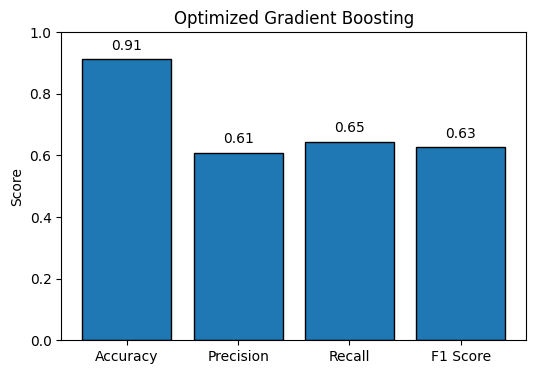

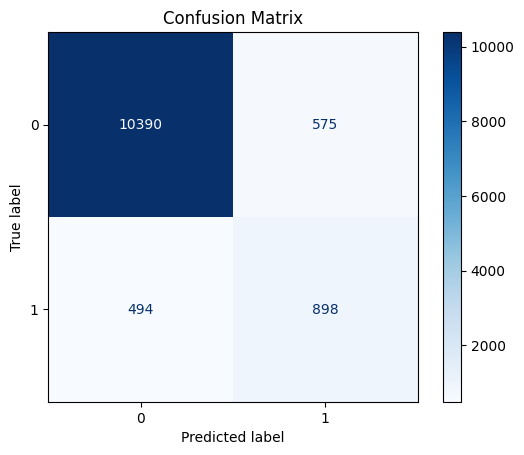

Accuracy: 0.9135
Recall: 0.6451
Precision: 0.6096
F1 Score: 0.6269
Confusion Matrix: TN=898, FP=494, FN=575, TP=10390


100%|===================| 12324/12357 [02:46<00:00]        

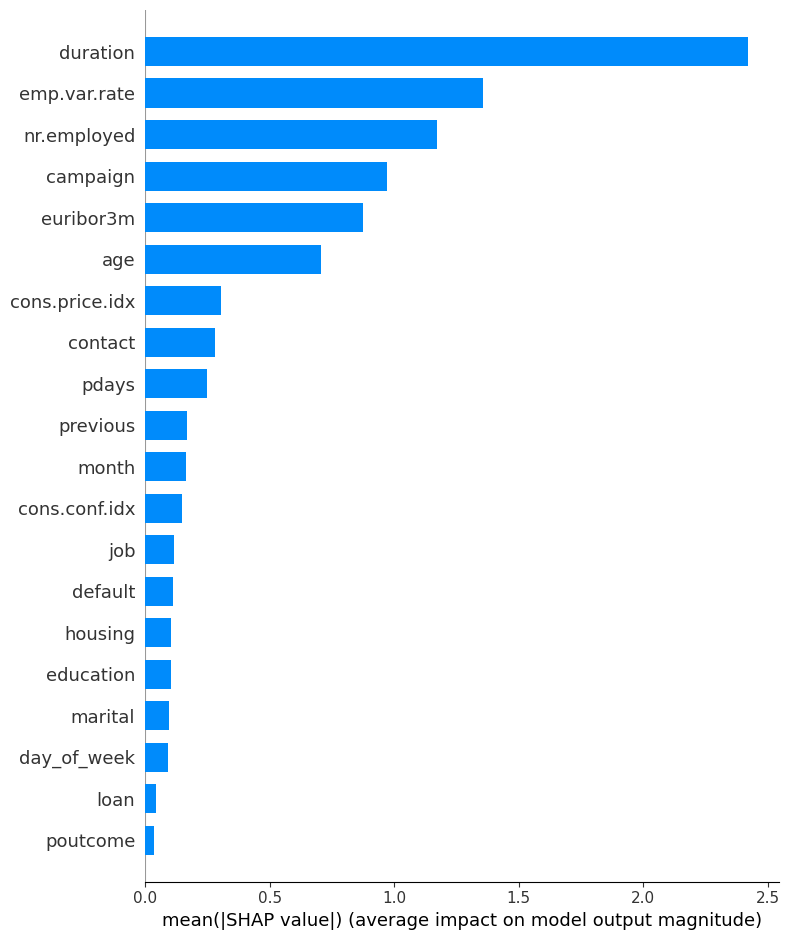

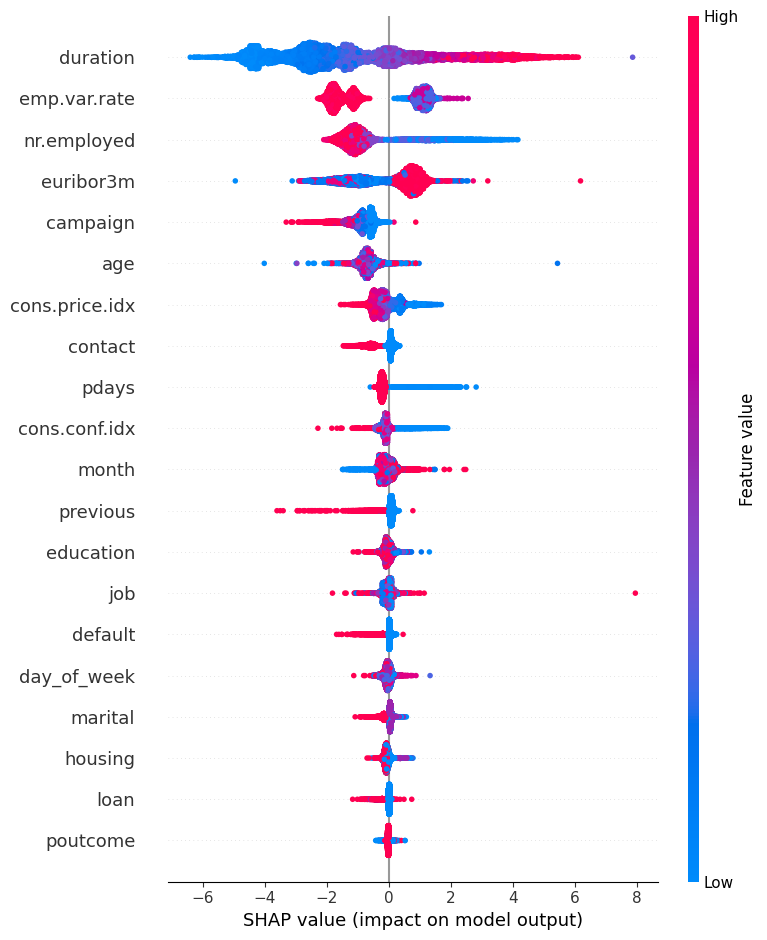

In [7]:
#Optimized Model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df)

opt_gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=7, random_state=42)
opt_gb.fit(X_resampled, y_resampled)

y_pred = opt_gb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

plt.figure(figsize=(6,4))
bars = plt.bar(metrics.keys(), metrics.values(), edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Optimized Gradient Boosting')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

import shap

# SHAP analysis for GradientBoostingClassifier
X_test_aligned = X_test[X_resampled.columns]

explainer = shap.Explainer(opt_gb, X_resampled)
shap_values = explainer(X_test_aligned, check_additivity=False)

# Summary plot (feature importance)
shap.summary_plot(shap_values[:100], X_test_aligned.iloc[:100], plot_type="bar")
# Detailed summary plot (beeswarm)
shap.summary_plot(shap_values, X_test_aligned)

XGBoost

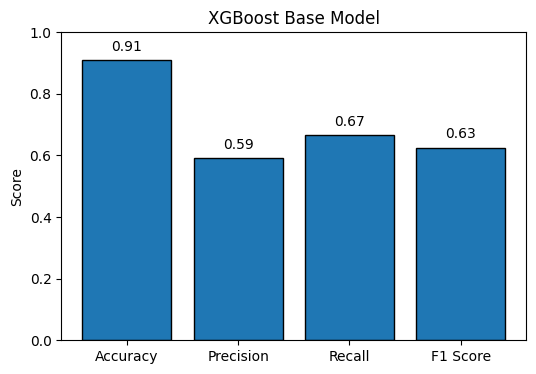

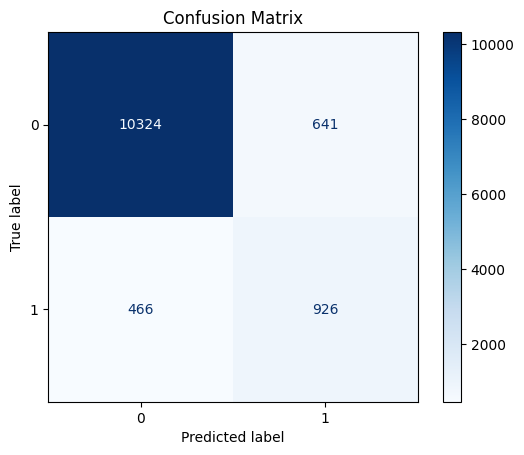

Accuracy: 0.9104
Recall: 0.6652
Precision: 0.5909
F1 Score: 0.6259
Confusion Matrix: TN=926, FP=466, FN=641, TP=10324


In [10]:
#Base Model
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df)

xgb = xgb.XGBClassifier(tree_method="hist", device="cuda", random_state=42)
xgb.fit(X_resampled, y_resampled)

y_pred = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

plt.figure(figsize=(6,4))
bars = plt.bar(metrics.keys(), metrics.values(), edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('XGBoost Base Model')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

In [ ]:
#Optimized Model GridSearchCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df)

param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [ 0.01, 0.1, 0.3, 0.5, 1.0],
    'subsample': [0.5, 0.8, 1.0]
}

xgbc = xgb.XGBClassifier(tree_method="hist", device="cuda", random_state=42)
grid_search = GridSearchCV(xgbc, param_grid, cv=cv_5fold, scoring='f1', n_jobs=-1)

grid_search.fit(X_resampled, y_resampled)
best_xgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

opt_xgb = xgb.XGBClassifier(
    n_estimators=best_xgb.n_estimators,
    learning_rate=best_xgb.learning_rate,
    max_depth=best_xgb.max_depth,
    subsample=best_xgb.subsample,
    tree_method="hist",
    device="cuda",
    random_state=42
)
opt_xgb.fit(X_resampled, y_resampled)
y_pred = opt_xgb.predict(X_test)


acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

print(f"Accuracy: {acc}")
print(f"Recall: {rec}")
print(f"Precision: {prec}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.8}
Accuracy: 0.9113862588006798
Recall: 0.6436781609195402
Precision: 0.5993311036789297
F1 Score: 0.6207135434707308
Confusion Matrix:
[[10366   599]
 [  496   896]]


In [4]:
#Optimized Model GridSearchCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df)

param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [ 0.01, 0.1, 0.3, 0.5, 1.0],
    'subsample': [0.5, 0.8, 1.0]
}

xgbc = xgb.XGBClassifier(tree_method="hist", device="cuda", random_state=42)
grid_search = GridSearchCV(xgbc, param_grid, cv=cv_5fold(), scoring='f1', n_jobs=-1)

grid_search.fit(X_resampled, y_resampled)
best_xgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

opt_xgb = xgb.XGBClassifier(
    n_estimators=best_xgb.n_estimators,
    learning_rate=best_xgb.learning_rate,
    max_depth=best_xgb.max_depth,
    subsample=best_xgb.subsample,
    tree_method="hist",
    device="cuda",
    random_state=42
)
opt_xgb.fit(X_resampled, y_resampled)
y_pred = opt_xgb.predict(X_test)


acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

print(f"Accuracy: {acc}")
print(f"Recall: {rec}")
print(f"Precision: {prec}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.5}
Accuracy: 0.910091446143886
Recall: 0.6429597701149425
Precision: 0.5931080185553347
F1 Score: 0.6170286108238539
Confusion Matrix: TN=895, FP=497, FN=614, TP=10351


c:\edu\t-predict-ensemble\venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [12:08:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


c:\edu\t-predict-ensemble\venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [15:41:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


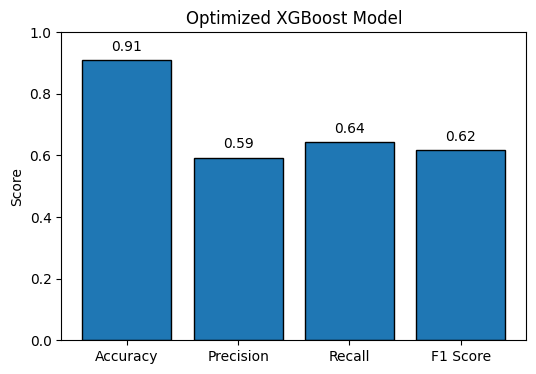

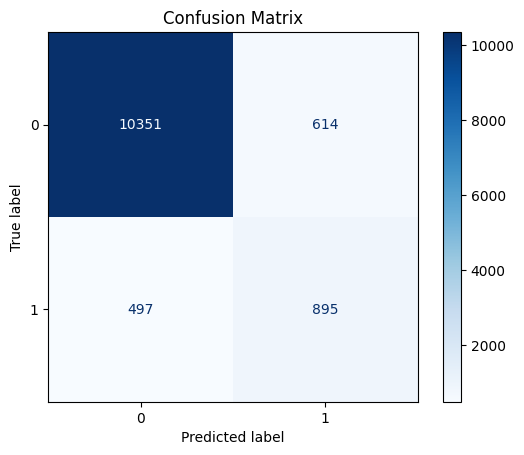

Accuracy: 0.9101
Recall: 0.6430
Precision: 0.5931
F1 Score: 0.6170
Confusion Matrix: TN=895, FP=497, FN=614, TP=10351


In [3]:
#Optimized Model
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *

X_resampled, X_test, y_resampled, y_test, encoders, scalers = preprocessing_pipeline(df)

opt_xgb = xgb.XGBClassifier(tree_method="hist", device="cuda", learning_rate=0.1, n_estimators=500, subsample=0.5, random_state=42)
opt_xgb.fit(X_resampled, y_resampled)

y_pred = opt_xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

plt.figure(figsize=(6,4))
bars = plt.bar(metrics.keys(), metrics.values(), edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Optimized XGBoost Model')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

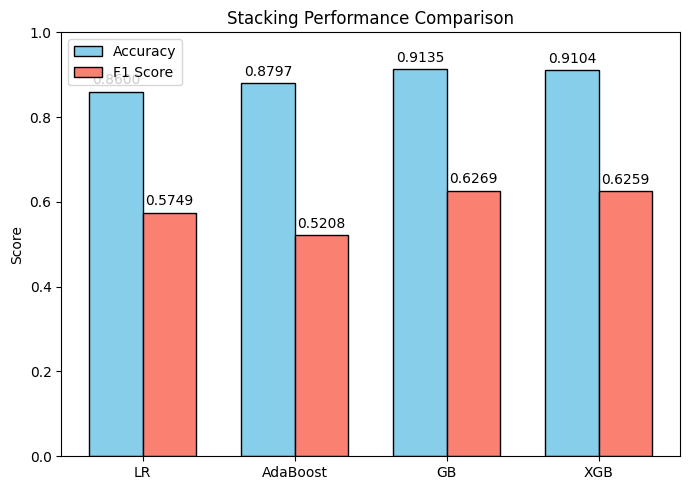

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the two variants
variants = ['LR', 'AdaBoost', 'GB', 'XGB']
accuracy = [0.8600, 0.8797, 0.9135, 0.9104]
f1_score = [0.5749, 0.5208, 0.6269, 0.6259]

x = np.arange(len(variants))  # label locations
width = 0.35  # width of the bars

plt.figure(figsize=(7, 5))
bars1 = plt.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue', edgecolor='black')
bars2 = plt.bar(x + width/2, f1_score, width, label='F1 Score', color='salmon', edgecolor='black')

plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Stacking Performance Comparison')
plt.xticks(x, variants)
plt.legend()

# Add value labels on top of each bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f}',
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()